# SARIMA Models - Lab

## Introduction

In this lesson, we'll reiterate what you learned previously, and talk about **integrated** models (hence ARIMA, which means as much as **integrated** ARMA), and extend to models that can cope with seasonality of time series.

## Objectives

You will be able to: 

* Demonstrate a conceptual understanding of ARIMA modelling components for time-series forecasting
* Pre-process the data to meet ARIMA based forecasting assumptions
* Identify best model parameters using grid search for p,d,q and seasonal p,d,q parameters
* Evaluate the ARIMA model with validation testing
* Predict and visualize future values and calculate confidence level for the predictions 

## ARIMA

Time series provide the opportunity to predict/forecast future values based on previous values. Such analyses can be used to forecast trends in economics, weather, and capacity planning etc. The specific properties of time-series data mean that specialized statistical methods are usually required.

So far, we have seen different techniques to make time series stationary, as well as White Noise, Moving Average, AR, MA and ARMA models. Now recall that your data needs to be detrended (or made **stationary**) before you can go along and use ARMA models. This is because it is easier to add trends and seasonality back in after you modeled your data. Now there are several issues with ARMA:

- ARMA models assume that the detrending already happened
- ARMA neglects that seasonality can happen

Let's summarize what we can observe when having time series in three situations:

1. A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.

2. A nonstationary series with significant dependence among values, but no seasonality. In this case we can use ARMA models after we detrended, or we can use an **integrated** ARMA model that detrends for us.

3. A nonstationary series with significant dependence among values, **and** seasonality. In this case we can use a seasonal arima or SARIMA model.

In this tutorial, we aim to produce reliable forecasts of a given time series by applying one of the most commonly used method for time series forecasting: ARIMA. After that we'll talk about seasonality and how to cope with it. 

One of the methods available in Python to model and predict future points of a time series is known as SARIMAX, which stands for **Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors**. Here, we will primarily focus on the **ARIMA** component, which is used to fit time-series data to better understand and forecast future points in the time series.

## Dataset

For this lab we shall use the dataset that we have seen before - "Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.," which collected CO2 samples from March 1958 to December 2001 (shown in lab1 if time-series). Let's bring in this data and plot as demosntrated earlier. You need to perform following tasks.

1. Import necessary libraries
2. import the CO2 dataset from `statsmodels`
3. Resample the data as monthly groups and take monthly average
4. Fill in the missing values with `Pandas.bfill()`
5. Plot the timeseries and inspect the head of data 

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [2]:
#Load the CO2 dataset from sm.datasets
dataset = sm.datasets.co2.load().data
df = pd.DataFrame(dataset)
df.head()

,date,co2
0,b'19580329',316.1
1,b'19580405',317.3
2,b'19580412',317.6
3,b'19580419',317.5
4,b'19580426',316.4


In [3]:
df['date'] = pd.to_datetime(df.date.str.decode("utf-8"))
df.set_index(df['date'], inplace=True)
df.head()

,date,co2
date,,
1958-03-29,1958-03-29,316.1
1958-04-05,1958-04-05,317.3
1958-04-12,1958-04-12,317.6
1958-04-19,1958-04-19,317.5
1958-04-26,1958-04-26,316.4


In [4]:
df.drop(['date'], axis=1, inplace=True)
df.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [5]:
df = df.asfreq('W-SAT')
df.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [6]:

# Use 'MS' string to group the data in buckets by start of the month
CO2 = df['co2'].resample('MS').mean()


In [7]:
# Fill in missing values
CO2 = CO2.fillna(CO2.bfill())

In [8]:
CO2.head()

date
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

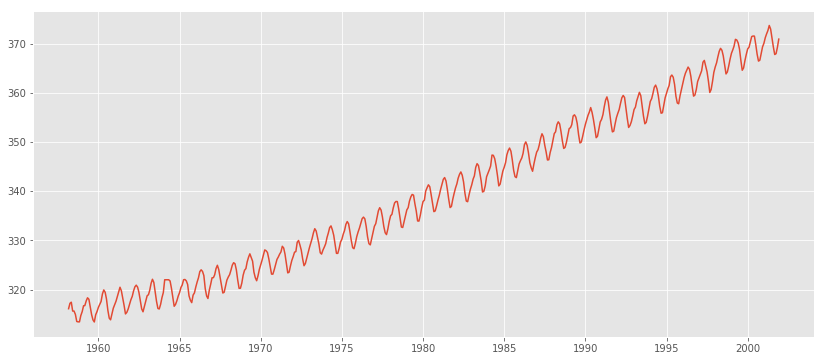

In [9]:


fig = plt.figure(figsize = (14,6))
plt.plot(CO2)



# Plot the time-series


# 1958-03-01    316.100000
# 1958-04-01    317.200000
# 1958-05-01    317.433333
# 1958-06-01    315.625000
# 1958-07-01    315.625000
# Freq: MS, Name: co2, dtype: float64

As noted earlier, the time series has spikes reflecting an obvious seasonality pattern, as well as an overall increasing trend.

## The ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **AutoregRessive Integrated Moving Average**. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

Let's have a quick introduction to ARIMA. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

### Number of AR (Auto-Regressive) terms (p): 

`p` is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

### Number of Differences (d):

`d` is the **Integrated** component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last *n* days is small. 

### Number of MA (Moving Average) terms (q): 

`q` is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where `e(i)` is the difference between the moving average at ith instant and actual value.

These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets:

* `(p, d, q)` are the non-seasonal parameters described above.
* `(P, D, Q)` follow the same definition but are applied to the seasonal component of the time series. 
* The term `s` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

A detailed article on these parameters is available [HERE](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.

## Parameter Selection for the ARIMA Time Series Model


The first step towards fitting an ARIMA model is to find the values of `ARIMA(p,d,q)(P,D,Q)s` that produce the desired output. Selection of these parameters requires domain expertise and time.  We shall first generate small ranges of these parameters and use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the `SARIMAX()` function from the statsmodels module and assess its overall quality. 

`SARIMAX` detailed documentation can be viewed [HERE](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

Let's begin by generating example combination of parameters that we wish to use.

1. Define p,q and d parameters to take any value from 0/1 using `range()` function. (Note: We can try larger values which can make our model computationally expensive to run, you can try this as an additional experiment)

2. Generate combinations for `(p,d,q)` using `itertools.product`.
3. Similarly, generate seasonal combinations as `(p,d,q)s`. Use s = 12 (constant)
4. Print some example combinations for seasonal ARIMA

In [3]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = None

# Generate all different combinations of p, q and q triplets
pdq = None

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = None


## AIC (Akaike Information Criterion) as Regularization Measure

For evaluating the model, we shall use the AIC (Akaike Information Criterion) value, which is provided by ARIMA models fitted using `statsmodels` library. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection. 

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. To achieve this, perform following tasks:

1. Initialize an empty list to store results
2. iterate through all the paramaters in pdq with parameters in seasonal pdq (nested loop ) to create a grid
3. Run `SARIMAX` from statsmodels for each iteration. Details can be found [HERE](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html). Set `enforce_stationarity` and `enforce_invertibility` to False. 
4. Get the results in each iteration with `model.fit()` and store the AIC values. 
5. Find the lowest AIC and select parameters for further analysis. 

NOTE: 
* Integrate exception handling with `continue`. 
* An overview of Akaike Information Criterion can be viewed [HERE](http://www.statisticshowto.com/akaikes-information-criterion/)



In [4]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value

            
            
# ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.34362403487
# ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727637512
# ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320024
#     .
#     .
#     .
#     .
# ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:327.9049164493077
# ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:444.1243686483202
# ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:277.78021965631604    

In [5]:
# Find the parameters with minimal AIC value.



# pdq         (1, 1, 1)
# pdqs    (1, 1, 1, 12)
# aic            277.78
# Name: 59, dtype: object

The output of our code suggests that `ARIMA(1, 1, 1)x(1, 1, 1, 12)` yields the lowest AIC value of `277.78`. We should therefore consider this to be optimal option out of all the models we have considered.

## Fitting an ARIMA Time Series Model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model.

In [6]:
# plug the optimal parameter values into a new SARIMAX model.

# Fit the model and print results

# ==============================================================================
#                  coef    std err          z      P>|z|      [0.025      0.975]
# ------------------------------------------------------------------------------
# ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
# ma.L1         -0.6254      0.077     -8.163      0.000      -0.776      -0.475
# ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
# ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
# sigma2         0.0972      0.004     22.632      0.000       0.089       0.106
# ==============================================================================

The model returns a lot of information, but we'll focus only on the table of coefficients. The `coef` column above shows the importance of each feature and how each one impacts the time series patterns.  The **P>|z|** provides  the significance of each feature weight. 

For our time-series, we see that each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

Next, we shall run model diagnostics to ensure that none of the assumptions made by the model have been violated. 

The `plot_diagnostics()` function on ARIMA output below:

In [7]:
# Use plot_diagnostics with results calculated above.


The purpose here to ensure that residuals remain un-correlated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweating of the model. 

Let's check for these assumptions from diagnostics plots.

* In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces has no correlations and provides a satisfactory fit to help forecast future values.


## Validating the Model

### One-step Ahead Forecasting

In order to validate the model, we start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. 

The `get_prediction()` and `conf_int()` attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.


[Documentation of `get_predictions()`](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_prediction.html)

[Documentation for `conf_int()`](http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMAResults.conf_int.html)

* Get the predictions from 1st January 1998 till 2002 ( end of time-series)

* Get the confidence intervals for all predictions.

* For `get_predictions()`, set the `dynamic` parameter to False to ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.




In [8]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

prediction = None
pred_conf = None

We shall now plot the real and forecasted values of the CO2 time series to assess how well we did. 

* Plot the observed values from the dataset, starting at 1990.
* Use `predicted_mean.plot()` with `prediction` to plot predictions.
* Plot the confidence intervals overlapping the predicted values.


In [9]:
# Plot real vs predicted values along with confidence interval

# Plot observed values

# Plot predicted values

# Plot the range for confidence intervals

# Set axes labels


The forecasts align with the true values  as seen above,with overall increase trend. We shall also check for the accuracy of our forecasts using  **MSE (Mean Squared Error)**. This will provide us with the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [10]:
# Get the Real and predicted values
CO2_forecasted = None
CO2_truth = None

# Compute the mean square error
mse = None

#print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error of our forecasts is 0.07

The MSE of our one-step ahead forecasts yields a value of 0.07, which is very low as it is close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

### Dynamic Forecasting

We can achieve a deeper insight into model's predictive power using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

Repeat above calculation for predictions post 1998. Use Dynamic forecasting by setting `dynamic` to True.

In [11]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = None
pred_dynamic_conf = None

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. All forecasted values (red line) match pretty closely to the ground truth (blue line), and are well within the confidence intervals of our forecast.



In [12]:
# Plot the dynamic forecast with confidence intervals as above

Once again, we quantify the predictive performance of our forecasts by computing the MSE.

In [13]:
# Extract the predicted and true values of our time series
CO2_forecasted = None
CO2_truth = None

# Compute the mean square error
mse = None
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error of our forecasts is 1.01

The predicted values obtained from the dynamic forecasts yield an MSE of 1.01. This is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. However, much of the interest around time series forecasting is the ability to forecast future values way ahead in time.



## Producing and Visualizing Forecasts

We will now describe how to leverage our seasonal ARIMA time series model to forecast future values. The `get_forecast()` attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [14]:
# Get forecast 500 steps ahead in future
prediction = None
# Get confidence intervals of forecasts
pred_conf = None

We can use the output of this code to plot the time series and forecasts of its future values.



In [15]:
# Plot future predictions with confidence intervals


Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.



## Bonus Exercises

* Change the start date of your dynamic forecasts to see how this affects the overall quality of your forecasts.
* Try more combinations of parameters to see if you can improve the goodness-of-fit of your model.
* Select a different metric to select the best model. For example, we used the AIC measure to find the best model, but you could seek to optimize the out-of-sample mean square error instead.


## Summary

In this lab, we described how to implement a seasonal ARIMA model in Python. We made extensive use of the pandas and statsmodels libraries and showed how to run model diagnostics, as well as how to produce forecasts of the CO2 time series.